In [72]:
#Date: 01/04/2021
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

# Loading all the libraries

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, fdr, threshold
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain
from nilearn import signal
import copy

%matplotlib inline

In [73]:
# Data directory

# Path to data in my PC
path = 'C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group 1\\*.txt'

# List of all the text files
sub_list = [x for x in glob.iglob(path, recursive=True)]

# Initiating empty list for all time points
time_p = []

########################################################################################################################################

# Iterating over ROIs of each subject
for sub in sub_list:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a,b) =  activation_values.shape
    time_p.append(a)

# Selecting the lowest value
time_dim = min(time_p)

print ('The minimum number of time points =', time_dim)

########################################################################################################################################


The minimum number of time points = 206


In [74]:
# Processing data to remove all ROIs having zero value for BOLD activation

# Initiating timeseries data as list
timeseries_3D = []

# All indices having zero value
zeroes = []

# Iterating over ROIs of each subject
for sub in sub_list:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis = 0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)
    
    zeroes.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D.append(activation_values[0:time_dim, :])

# Converting timeseries data in numpy array
timeseries_3D = np.asarray(timeseries_3D)

# Unique zero values for all ROIs
zeroes = np.unique(zeroes).astype(int)

# Removing ROIs having zeroes
timeseries_3D = np.delete(timeseries_3D, zeroes, axis=2)

# Dimension check for the output
print ('Dimensions (Subjects, Timepoints, ROIs) =', timeseries_3D.shape)

Dimensions (Subjects, Timepoints, ROIs) = (29, 206, 268)


In [75]:
# Converting the numpy data to panda dataframe

# Initiating timeseries as dictionary for all records
timeseries = {}

# Converting numpy data into panda dataframe for each participant
for sub in range(timeseries_3D.shape[0]):
    timeseries[sub] = pd.DataFrame(timeseries_3D[sub, :, :])

In [76]:
# Standardising the timeseries by z-transforming

# Initialising standard timeseries dictionary
z_timeseries = {}

# Using z-score to standardise each value
for sub in range(timeseries_3D.shape[0]):
  z_timeseries[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  z_timeseries[sub] = pd.DataFrame(z_timeseries[sub])

print ('Dimensions of each subject =', z_timeseries[sub].shape)
print ('No. of subjects =', len(z_timeseries))

Dimensions of each subject = (206, 268)
No. of subjects = 29


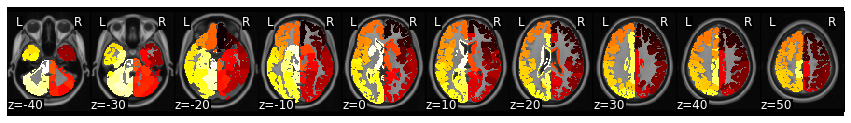

In [77]:
# Mask with 268 parcellations

# Importing mask from Neurovault
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

In [78]:
# Selecting ROI for ISC analysis

def get_subject_roi(data = dict, roi = int):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

# Testing for region 78
# roi = 78
# roi_roi = get_subject_roi(z_timeseries, roi)
# print('Dimensions of data for ROI', roi,'=', roi_roi.shape)

In [79]:
# Testing - ISC for ROI = 78, and no. of bootstraps = 10000

# stats = isc(get_subject_roi(z_timeseries, 78), n_bootstraps=10000, metric='median', method='bootstrap')
# print(f"ISC: {stats['isc']:.02}, p = {stats['p']:.03}")

In [80]:
# Running ISC on all ROIs

# Intialising isc and p-value dictionaries
isc_r, isc_p = {}, {}

# Iterating over each ROI
for roi in range(268):
    stats = isc(get_subject_roi(z_timeseries, roi), n_bootstraps=10000, metric='median', method='bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']

# Converting correlation and p-value back into a Brain_Data instance
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


In [81]:
# Visualisation of regions of high correlation

# print ('Degree of correlation in Parcels')
# isc_r_brain.plot(cmap='RdBu_r')

# print ('Significance of correlation in Parcels')
# isc_p_brain.plot(cmap='RdBu_r')

In [82]:
# Number of significant regions after thresholding

# List of ROIs
rois = [x for x in range(1, 269)] #Using 1 to 269 instead of 268 because the reference Yeo 7 network csv labels parcel from 1, not 0

# Significant ROIS
sig_roi = pd.Series(isc_p).values <= fdr(isc_p_brain.data)
total_sig_roi = np.sum(sig_roi)
r_list = list(zip(rois, sig_roi))

sig_rois = []
corr_p = []
corr_isc = []

for a,b in r_list:
    if b == True:
        sig_rois.append(a)
        corr_p.append(isc_p[a-1])
        corr_isc.append(isc_r[a-1])

# print ('Significant ROIs =', sig_rois)
print ('Number of significant parcels =', total_sig_roi)

Number of significant parcels = 88


Visualising Correlation



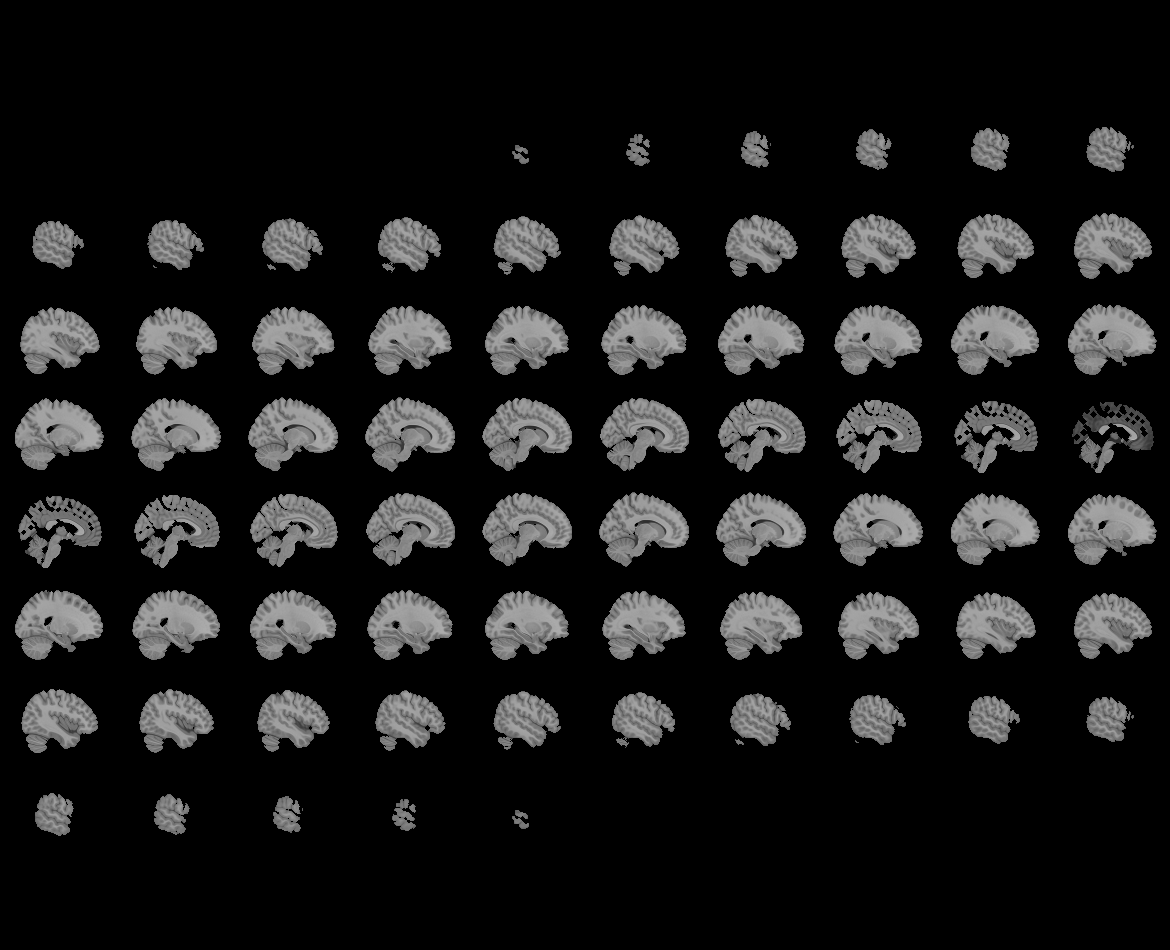
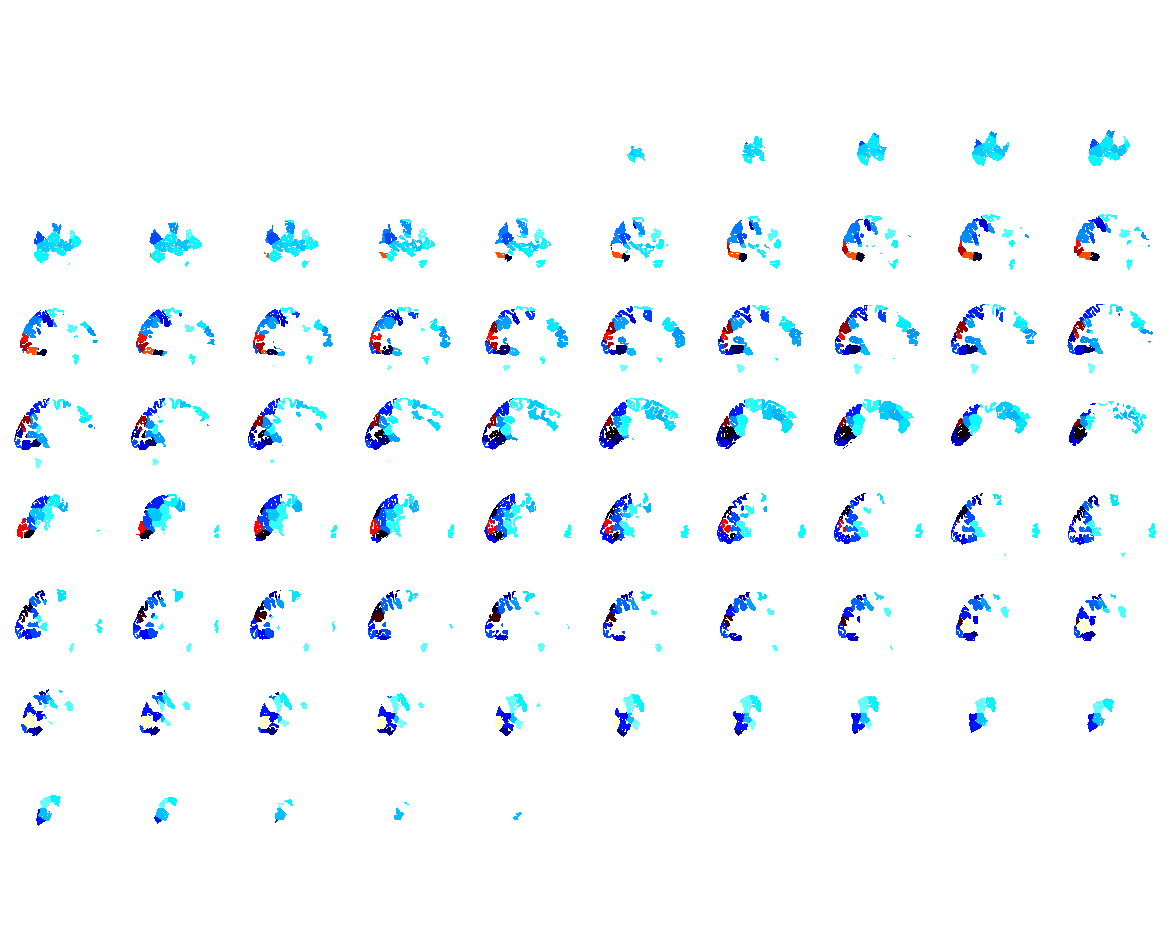

In [83]:
# Mapping correlation

print ('Visualising Correlation')
view_img(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti(), symmetric_cmap = False)


In [84]:
# view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti())


Correlations


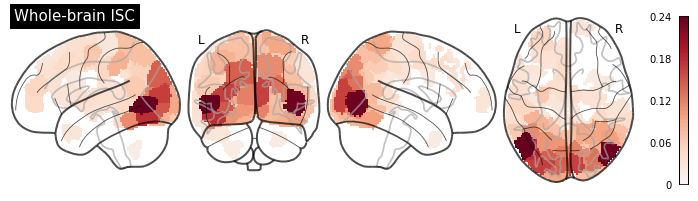

In [85]:
# Projection of correlation values on the brain glass

print ('Correlations')
plot_glass_brain(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='Whole-brain ISC')


In [86]:
# Yeo 7 Network

# Reading Yeo 7 csv file
yeo7 = pd.read_csv('C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Data and Others\\shen_268_parcellation_networklabels[84497].csv')

# Initiating the empty list
network = {}

# Zipping 2 columns in the file
z_list = list(zip(yeo7['Network'], yeo7['Node']))

for a, b in z_list:
    if a not in network:
        network[a] = []
    if a in network:
        network[a].append(b)

# # Sanity check for all the assignment of all values
# sum = 0

# for i in network:
#     count = len(network[i])
#     print ('Network', i, ', No. of regions =', count)
#     sum = sum+count

# print ('Number of items sorted in keys =', sum)


In [87]:
# Number of significant regions in Yeo Network

# Dict of names of Yeo7 network
yeo7_net = {1: 'VIS', 2: 'SMN', 3: 'DAN', 4: 'VAN', 5: 'LIM', 6: 'FPN', 7: 'DMN', 8: 'SUB'}

# Making a copy of original network
sig_network = copy.deepcopy(network)

# Inititating count (Optional)
summ = 0

# List of number of parcels in each network
count = []
n_num = []

# Iterating over each entry
for i in network:
    # Subset of common values 
    sig_network[i] = set(network[i]) & set(sig_rois)
    # Counting of parcels in each network (Optional)
    countt = len(sig_network[i])
    count.append(countt)
    n_num.append(yeo7_net[i])
    # print('Network', i, ', No. of regions =', countt)
    summ = summ+countt

# List of significant parcels in each network
count = list(zip(n_num, count))

# # Sanity check
# print('Number of items sorted in keys =', summ)


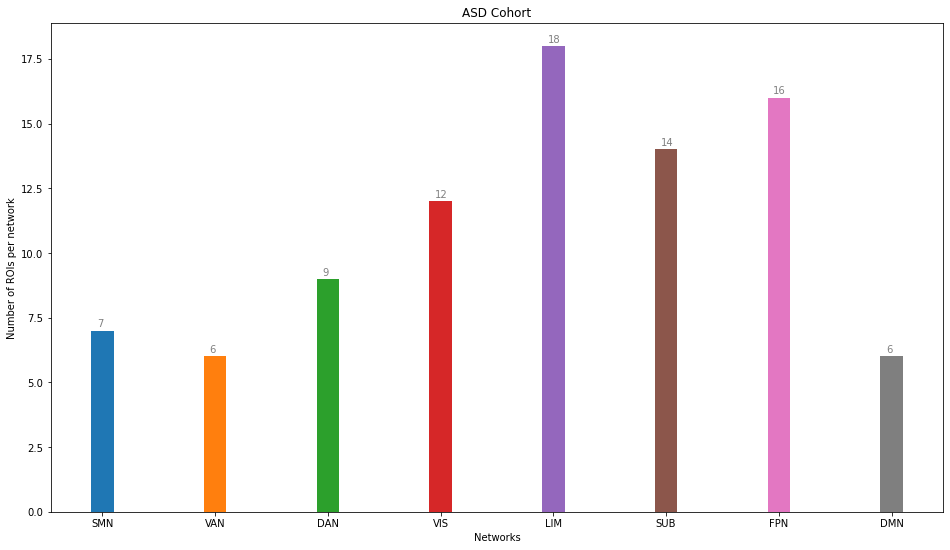

In [88]:
# Plotting number of Yeo7 Network areas

fig, ax = plt.subplots(figsize =(16, 9))


for a,b in count:
    ax.bar(a, b, width=0.2)

ax.set_title('ASD Cohort')
ax.set_ylabel('Number of ROIs per network')
ax.set_xlabel('Networks')

for i in ax.patches:
    plt.text(i.get_x()+0.05, i.get_height()+0.15, str(round((i.get_height()), 2)), fontsize=10, color='grey')


In [89]:
# Sorting the network IDs in list

# Initiating empty list for network
net = []

for i in network.items():
    for j in sig_rois:
        if j in i[1]:
            net.append(i[0])


In [90]:
# Saving ISC values to a CSV file

sig_isc_val = pd.DataFrame([])
sig_isc_val['ROI'] = sig_rois
sig_isc_val['ISC'] = corr_isc
sig_isc_val['p'] = corr_p
sig_isc_val['Network'] = net

sig_isc_val.to_csv('C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group 1\\Processing\\ASD_ISC.csv', index=False)


In [91]:
new_file = 'C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group 1\\Processing\\ASD.nii.gz'

threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).write(new_file)
